In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
seed = 314
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [5]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  HEAWIHTQ_16_29_35
NN-MODEL FILENAME:  ./models/HEAWIHTQ_16_29_35_NN.pt


In [6]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [7]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [8]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [9]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 100000

In [10]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 7000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  30


In [11]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
        bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

        good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [13]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.925
LENGTH_ABS_MIN = 0.375

In [14]:
# SET GRANULARITY
HI_GRAIN = 30
LO_GRAIN = 30
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  30
LO_GRAIN =  30


In [15]:
def mp_node_run(node_id, boundary, iteration):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
    
    # Mean values of pole length deviate by 40% from original value
    scaling_factor = 0.8 + (1.8 - 0.8) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                                                                 C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]
    ###############################################
#     LENGTH_MAX = length_mean + 0.05
#     LENGTH_MIN = length_mean - 0.05
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN, LENGTH_MAX, LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
                                    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
    
#     my_dqn = D3QN()
#     my_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
#     my_dqn.eval_net.eval()
#     my_QFILE   = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
    my_Q_TABLE = np.load(node_QFILE)
#     my_Q_TABLE = my_dqn.get_qvals(state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
    if iteration < 3:
        my_EPSILON   = (iteration+1) * 0.2 + np.random.uniform(-0.1,0.1)
    else:
        my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

                     
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]
    
#     LENGTH_MAX = exp_rec[:,4].max() + 0.25*np.abs(exp_rec[:,4].max())
#     LENGTH_MIN = exp_rec[:,4].min() - 0.25*np.abs(exp_rec[:,4].min())

    # CLAMP STATE VALUE BORDERS
    ###############################################
#     C_POS_MAX = clamp(C_POS_ABS_MIN, C_POS_MAX, C_POS_ABS_MAX)
#     C_POS_MIN = clamp(C_POS_ABS_MIN, C_POS_MIN, C_POS_ABS_MAX) 

#     C_VEL_MAX = clamp(C_VEL_ABS_MIN, C_VEL_MAX, C_VEL_ABS_MAX)
#     C_VEL_MIN = clamp(C_VEL_ABS_MIN, C_VEL_MIN, C_VEL_ABS_MAX) 

#     P_ANG_MAX = clamp(P_ANG_ABS_MIN, P_ANG_MAX, P_ANG_ABS_MAX)
#     P_ANG_MIN = clamp(P_ANG_ABS_MIN, P_ANG_MIN, P_ANG_ABS_MAX) 

#     P_VEL_MAX = clamp(P_VEL_ABS_MIN, P_VEL_MAX, P_VEL_ABS_MAX)
#     P_VEL_MIN = clamp(P_VEL_ABS_MIN, P_VEL_MIN, P_VEL_ABS_MAX) 

    LENGTH_MAX = clamp(LENGTH_ABS_MIN, LENGTH_MAX + 0.075, LENGTH_ABS_MAX)
    LENGTH_MIN = clamp(LENGTH_ABS_MIN, LENGTH_MIN - 0.075, LENGTH_ABS_MAX)
    ###############################################
    
    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [16]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [17]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])



# GET Q-VALUES 
start = timeit.default_timer()
% memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
np.save(node_QFILE, init_q_table)

peak memory: 11267.32 MiB, increment: 10197.70 MiB
Quantization TIME:  0.09 minutes


In [18]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES



ITERATION # 0
MEAN TABULAR EPSILON =  0.2
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 0: 8
REAL TIME TO GENERATE 18467 EXPERIENCES:0:00:02.535876


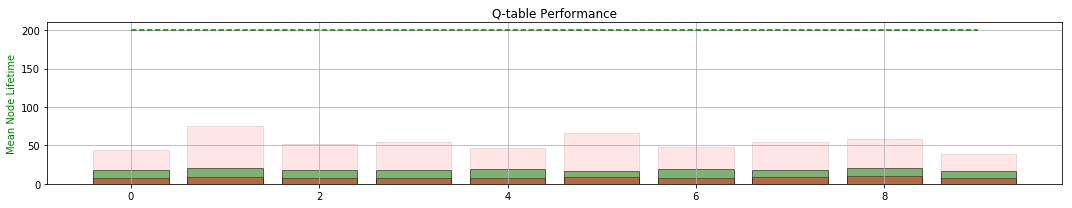

GOOD MEMORY COUNTER:  17467
BAD MEMORY COUNTER:  1000
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  195.545
Validating... MEAN TIME:  192.02
Validating... MEAN TIME:  181.21
Validating... MEAN TIME:  186.01
Validating... MEAN TIME:  191.915
TRAINING TIME:0:00:46.875501


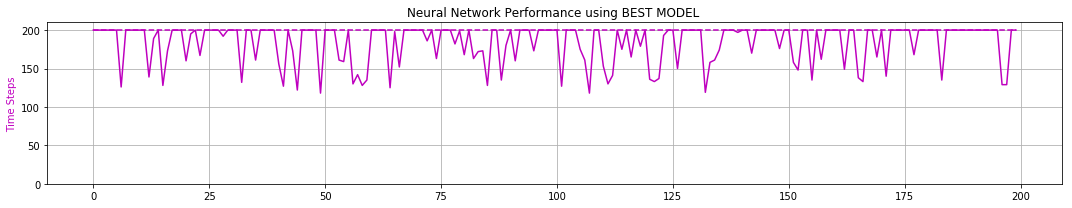

0 -max- [ 0.216  1.553  0.209  3.032  0.550]
0 -min- [-0.305 -2.350 -0.208 -2.346  0.375]

1 -max- [ 0.226  1.706  0.209  2.733  0.599]
1 -min- [-0.539 -2.074 -0.208 -2.656  0.400]

2 -max- [ 0.189  1.601  0.209  2.709  0.650]
2 -min- [-0.372 -1.961 -0.208 -2.459  0.452]

3 -max- [ 0.197  1.573  0.209  2.641  0.699]
3 -min- [-0.309 -1.765 -0.209 -2.524  0.501]

4 -max- [ 0.185  1.548  0.209  2.705  0.748]
4 -min- [-0.589 -2.341 -0.207 -2.354  0.550]

5 -max- [ 0.207  1.421  0.209  2.774  0.800]
5 -min- [-0.523 -2.163 -0.209 -2.251  0.600]

6 -max- [ 0.201  1.593  0.209  2.670  0.850]
6 -min- [-0.363 -2.275 -0.209 -2.380  0.651]

7 -max- [ 0.199  1.021  0.208  3.036  0.900]
7 -min- [-0.285 -2.128 -0.206 -1.498  0.701]

8 -max- [ 0.429  1.928  0.209  2.726  0.925]
8 -min- [-0.347 -1.779 -0.209 -2.483  0.750]

9 -max- [ 0.169  1.546  0.209  3.239  0.925]
9 -min- [-0.257 -2.294 -0.205 -2.294  0.800]

peak memory: 12137.82 MiB, increment: 10012.02 MiB
Quantization TIME:  0.09 minutes


ITER

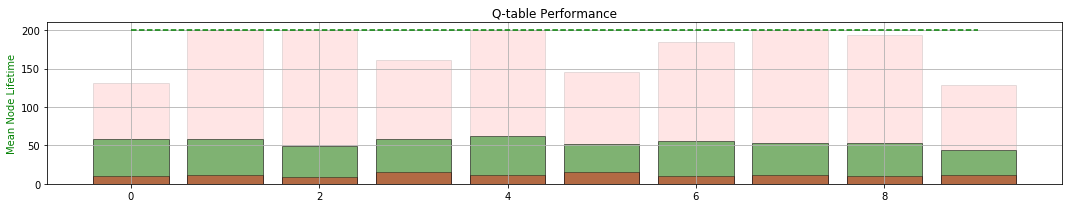

GOOD MEMORY COUNTER:  70778
BAD MEMORY COUNTER:  1995
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  195.025
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.96
TRAINING TIME:0:00:49.423794


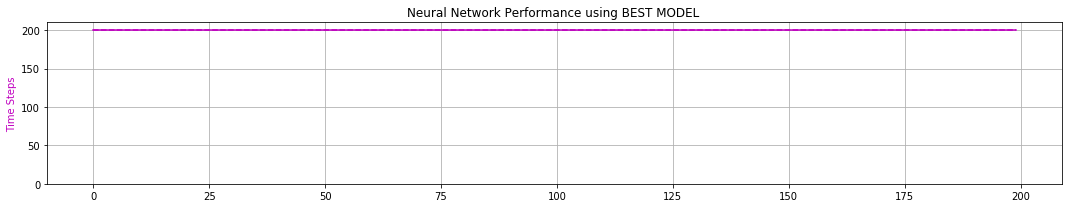

0 -max- [ 0.753  1.568  0.209  2.393  0.550]
0 -min- [-1.522 -2.637 -0.209 -2.219  0.375]

1 -max- [ 2.365  2.489  0.209  1.717  0.600]
1 -min- [-1.625 -2.423 -0.209 -1.909  0.400]

2 -max- [ 1.188  2.125  0.209  2.101  0.649]
2 -min- [-1.311 -2.180 -0.209 -2.328  0.450]

3 -max- [ 1.321  1.666  0.207  1.660  0.700]
3 -min- [-1.509 -2.385 -0.209 -2.235  0.500]

4 -max- [ 1.388  2.072  0.209  1.798  0.749]
4 -min- [-1.662 -2.395 -0.209 -2.130  0.550]

5 -max- [ 1.510  1.840  0.204  1.690  0.800]
5 -min- [-1.495 -2.359 -0.209 -2.189  0.600]

6 -max- [ 0.998  1.857  0.209  1.836  0.850]
6 -min- [-1.481 -2.382 -0.209 -2.399  0.650]

7 -max- [ 1.453  2.453  0.209  2.095  0.900]
7 -min- [-1.094 -2.029 -0.209 -1.923  0.701]

8 -max- [ 1.342  1.509  0.207  1.539  0.925]
8 -min- [-1.614 -2.581 -0.209 -1.982  0.750]

9 -max- [ 1.670  2.111  0.209  1.999  0.925]
9 -min- [-1.565 -2.069 -0.209 -2.650  0.800]

peak memory: 12247.44 MiB, increment: 10010.91 MiB
Quantization TIME:  0.1 minutes


ITERA

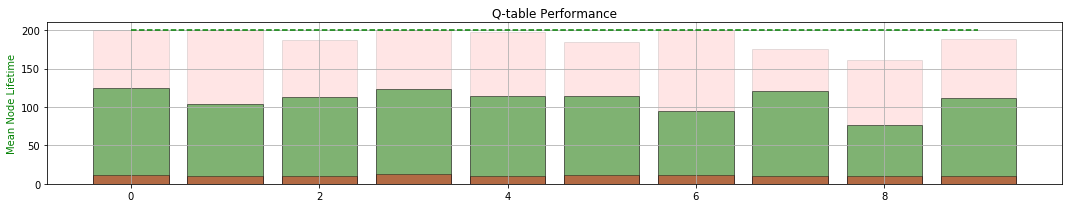

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  2990
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  191.595
Validating... MEAN TIME:  197.575
Validating... MEAN TIME:  176.625
Validating... MEAN TIME:  180.87
Validating... MEAN TIME:  167.195
TRAINING TIME:0:00:46.923006


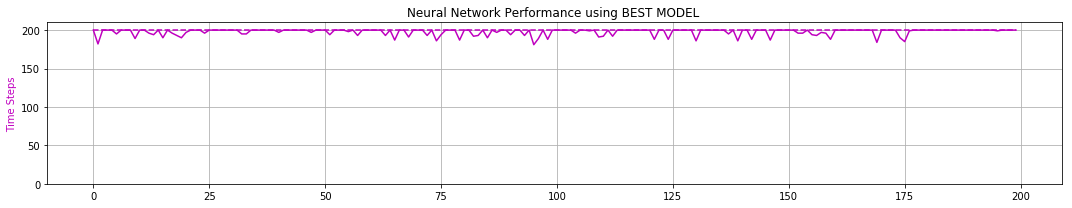

0 -max- [ 0.245  1.508  0.209  1.534  0.550]
0 -min- [-1.896 -2.440 -0.209 -1.930  0.375]

1 -max- [ 0.276  1.523  0.208  2.178  0.599]
1 -min- [-2.143 -2.531 -0.209 -2.113  0.401]

2 -max- [ 0.201  1.517  0.189  1.574  0.650]
2 -min- [-2.009 -2.438 -0.209 -2.106  0.450]

3 -max- [ 0.205  1.319  0.207  1.498  0.700]
3 -min- [-2.077 -2.383 -0.209 -2.631  0.500]

4 -max- [ 0.176  1.776  0.203  1.611  0.748]
4 -min- [-2.114 -2.403 -0.209 -2.590  0.551]

5 -max- [ 0.181  1.405  0.206  1.586  0.800]
5 -min- [-2.193 -2.557 -0.209 -1.997  0.600]

6 -max- [ 0.265  1.540  0.208  1.741  0.850]
6 -min- [-2.293 -2.571 -0.209 -2.193  0.650]

7 -max- [ 0.160  1.221  0.195  1.681  0.900]
7 -min- [-2.234 -2.519 -0.209 -2.130  0.700]

8 -max- [ 0.265  1.516  0.208  1.980  0.925]
8 -min- [-1.983 -2.374 -0.209 -2.499  0.750]

9 -max- [ 0.193  1.332  0.142  1.320  0.925]
9 -min- [-2.379 -2.745 -0.209 -2.046  0.800]

peak memory: 12449.80 MiB, increment: 10168.38 MiB
Quantization TIME:  0.1 minutes


ITERA

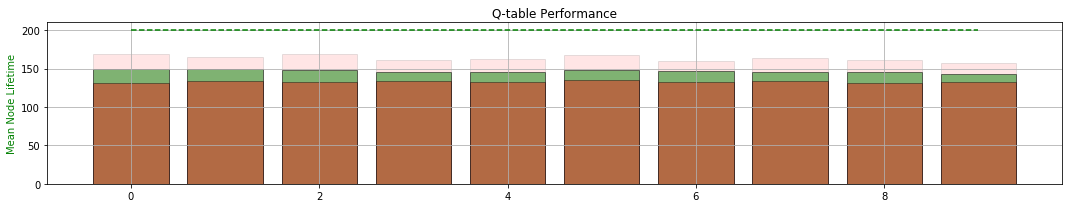

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  3990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  161.995
Validating... MEAN TIME:  164.09
Validating... MEAN TIME:  165.58
Validating... MEAN TIME:  189.44
Validating... MEAN TIME:  194.185
TRAINING TIME:0:00:45.108278


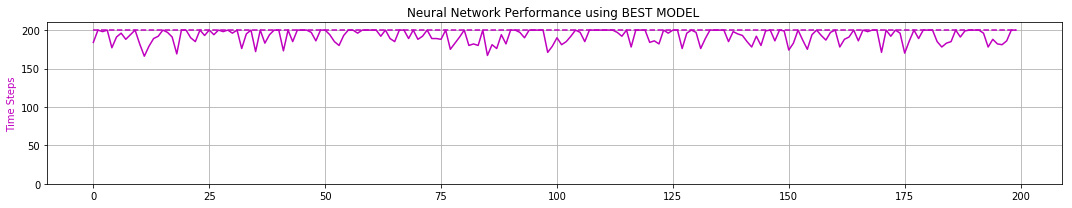

0 -max- [ 0.121  0.816  0.048  0.901  0.550]
0 -min- [-2.400 -2.754 -0.209 -1.154  0.375]

1 -max- [ 0.114  0.984  0.049  0.959  0.599]
1 -min- [-2.400 -2.761 -0.201 -1.435  0.400]

2 -max- [ 0.137  0.827  0.050  0.759  0.649]
2 -min- [-2.399 -2.697 -0.206 -1.175  0.451]

3 -max- [ 0.146  0.968  0.051  0.823  0.700]
3 -min- [-2.400 -2.609 -0.206 -1.401  0.500]

4 -max- [ 0.125  0.824  0.050  0.844  0.749]
4 -min- [-2.400 -2.617 -0.200 -1.191  0.550]

5 -max- [ 0.145  0.829  0.050  0.923  0.798]
5 -min- [-2.400 -2.600 -0.204 -1.216  0.600]

6 -max- [ 0.127  0.960  0.049  0.980  0.849]
6 -min- [-2.400 -2.570 -0.201 -1.461  0.650]

7 -max- [ 0.136  0.928  0.050  0.970  0.900]
7 -min- [-2.400 -2.611 -0.189 -1.446  0.702]

8 -max- [ 0.134  0.828  0.049  0.880  0.925]
8 -min- [-2.399 -2.433 -0.190 -1.225  0.750]

9 -max- [ 0.167  1.006  0.049  1.170  0.925]
9 -min- [-2.400 -2.429 -0.178 -1.399  0.800]

peak memory: 12656.14 MiB, increment: 10323.32 MiB
Quantization TIME:  0.1 minutes


ITERA

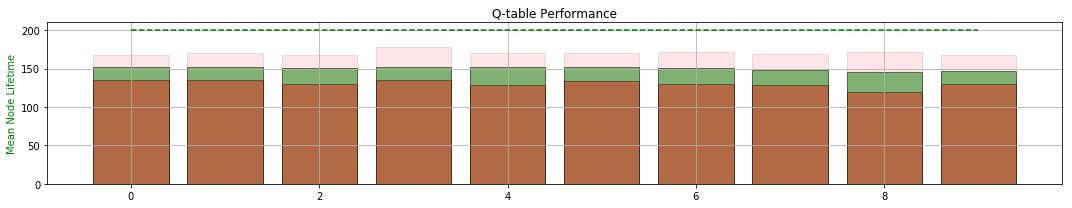

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  4990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  176.23
Validating... MEAN TIME:  158.735
Validating... MEAN TIME:  165.435
Validating... MEAN TIME:  174.625
Validating... MEAN TIME:  151.995
TRAINING TIME:0:00:43.203420


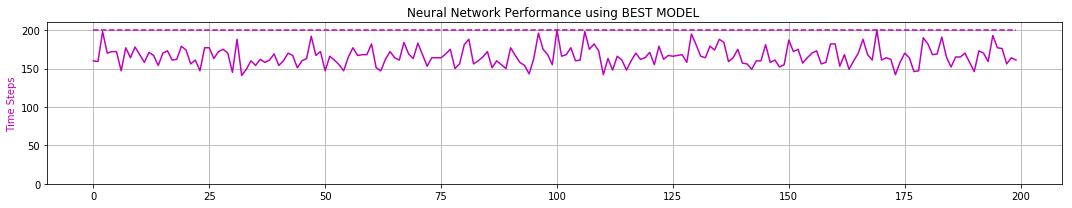

0 -max- [ 0.120  0.992  0.049  1.242  0.550]
0 -min- [-2.400 -2.962 -0.209 -1.455  0.375]

1 -max- [ 0.141  1.020  0.050  1.246  0.600]
1 -min- [-2.400 -2.991 -0.209 -1.373  0.401]

2 -max- [ 0.130  1.021  0.051  1.280  0.649]
2 -min- [-2.400 -2.970 -0.209 -1.468  0.451]

3 -max- [ 0.170  1.000  0.057  1.307  0.700]
3 -min- [-2.400 -2.967 -0.209 -1.578  0.500]

4 -max- [ 0.167  0.996  0.050  1.338  0.749]
4 -min- [-2.399 -2.995 -0.209 -1.441  0.550]

5 -max- [ 0.127  0.946  0.063  1.299  0.799]
5 -min- [-2.399 -3.100 -0.209 -1.633  0.600]

6 -max- [ 0.137  0.832  0.068  1.472  0.849]
6 -min- [-2.400 -2.967 -0.208 -1.574  0.651]

7 -max- [ 0.130  1.164  0.056  1.397  0.900]
7 -min- [-2.400 -2.918 -0.209 -1.675  0.700]

8 -max- [ 0.168  1.202  0.087  1.450  0.925]
8 -min- [-2.399 -2.967 -0.208 -1.744  0.751]

9 -max- [ 0.170  1.139  0.070  1.504  0.925]
9 -min- [-2.398 -2.998 -0.209 -1.709  0.800]

peak memory: 12419.11 MiB, increment: 10073.70 MiB
Quantization TIME:  0.1 minutes


ITERA

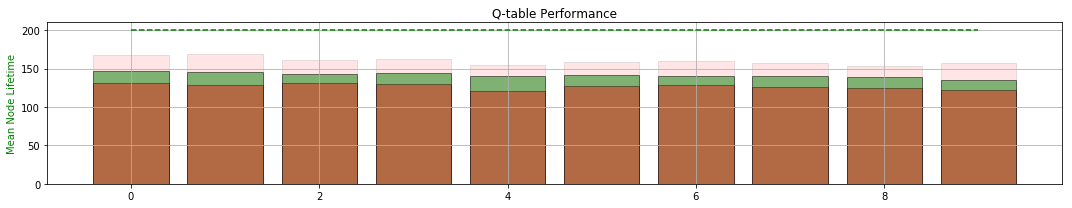

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  5990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  170.02
Validating... MEAN TIME:  142.615
Validating... MEAN TIME:  185.975
Validating... MEAN TIME:  159.975
Validating... MEAN TIME:  186.115
TRAINING TIME:0:00:43.809905


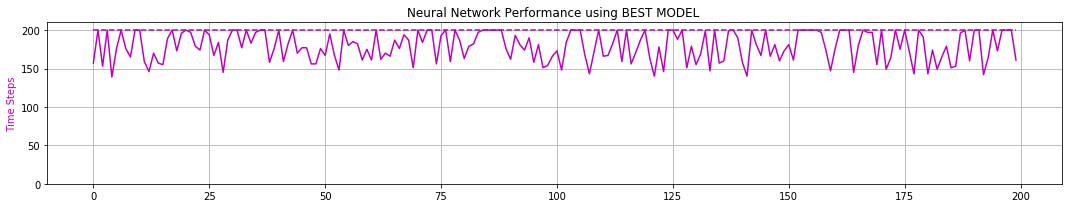

0 -max- [ 0.129  0.827  0.050  1.287  0.550]
0 -min- [-2.399 -3.168 -0.209 -1.216  0.375]

1 -max- [ 0.124  0.827  0.056  1.279  0.600]
1 -min- [-2.398 -3.192 -0.209 -1.219  0.401]

2 -max- [ 0.133  0.952  0.050  1.060  0.650]
2 -min- [-2.399 -3.179 -0.209 -1.447  0.450]

3 -max- [ 0.139  0.829  0.050  1.410  0.699]
3 -min- [-2.399 -3.372 -0.209 -1.563  0.500]

4 -max- [ 0.127  0.946  0.049  1.448  0.749]
4 -min- [-2.400 -3.385 -0.209 -1.461  0.550]

5 -max- [ 0.137  0.827  0.050  1.544  0.800]
5 -min- [-2.400 -3.379 -0.209 -1.256  0.600]

6 -max- [ 0.137  0.962  0.049  1.243  0.850]
6 -min- [-2.400 -3.193 -0.209 -1.500  0.650]

7 -max- [ 0.168  1.192  0.049  1.341  0.899]
7 -min- [-2.400 -3.303 -0.209 -1.710  0.701]

8 -max- [ 0.170  1.139  0.050  1.363  0.925]
8 -min- [-2.399 -3.327 -0.209 -1.709  0.750]

9 -max- [ 0.163  1.210  0.050  1.315  0.925]
9 -min- [-2.398 -3.193 -0.208 -1.729  0.800]

peak memory: 12382.52 MiB, increment: 10053.12 MiB
Quantization TIME:  0.1 minutes


ITERA

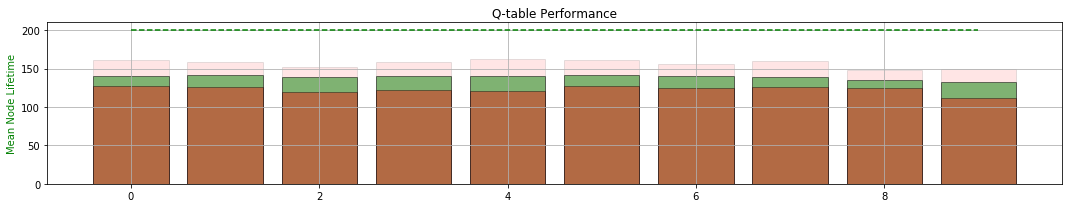

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  6990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  130.115
Validating... MEAN TIME:  171.275
Validating... MEAN TIME:  162.295
Validating... MEAN TIME:  198.695
Validating... MEAN TIME:  131.47
TRAINING TIME:0:00:41.620235


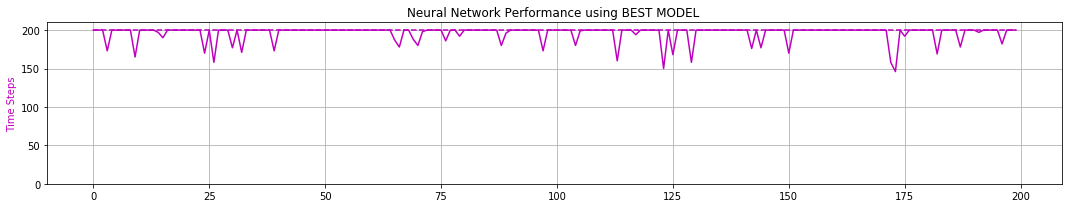

0 -max- [ 0.127  0.827  0.051  0.769  0.549]
0 -min- [-2.399 -2.758 -0.209 -1.190  0.375]

1 -max- [ 0.130  0.824  0.050  0.989  0.600]
1 -min- [-2.399 -2.785 -0.209 -1.232  0.401]

2 -max- [ 0.145  0.829  0.050  0.823  0.650]
2 -min- [-2.397 -2.732 -0.209 -1.210  0.451]

3 -max- [ 0.129  0.946  0.049  0.820  0.700]
3 -min- [-2.398 -2.753 -0.209 -1.461  0.500]

4 -max- [ 0.139  0.966  0.050  0.966  0.749]
4 -min- [-2.399 -2.799 -0.209 -1.425  0.550]

5 -max- [ 0.137  0.928  0.049  0.810  0.799]
5 -min- [-2.400 -2.794 -0.209 -1.479  0.600]

6 -max- [ 0.155  0.827  0.049  0.816  0.849]
6 -min- [-2.399 -2.750 -0.209 -1.282  0.650]

7 -max- [ 0.141  1.020  0.050  0.797  0.900]
7 -min- [-2.399 -2.781 -0.209 -1.428  0.700]

8 -max- [ 0.143  1.015  0.050  0.933  0.925]
8 -min- [-2.400 -2.797 -0.209 -1.450  0.750]

9 -max- [ 0.162  1.015  0.051  0.951  0.925]
9 -min- [-2.400 -2.920 -0.209 -1.491  0.800]

peak memory: 12469.24 MiB, increment: 10114.14 MiB
Quantization TIME:  0.11 minutes


ITER

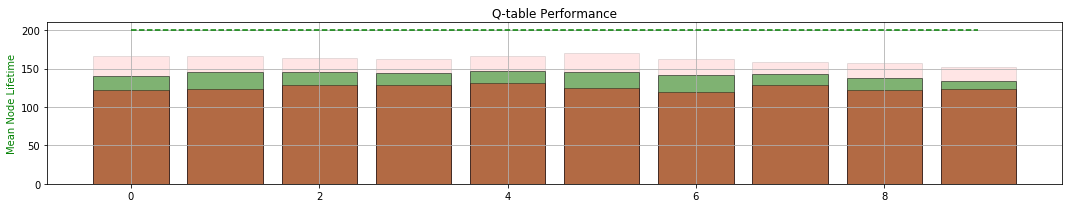

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  7990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  187.065
Validating... MEAN TIME:  199.725
Validating... MEAN TIME:  189.0
Validating... MEAN TIME:  177.265
Validating... MEAN TIME:  188.1
TRAINING TIME:0:00:47.603703


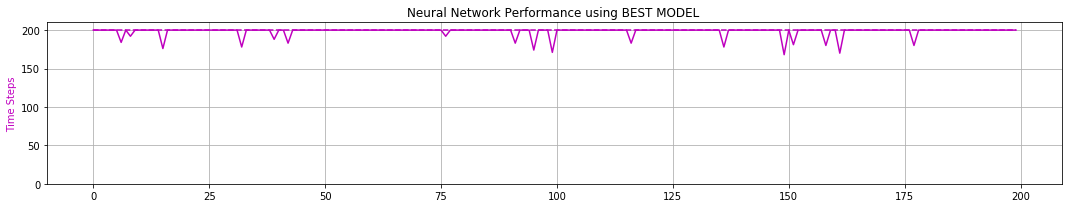

0 -max- [ 0.146  0.626  0.050  0.713  0.550]
0 -min- [-2.397 -2.761 -0.209 -0.891  0.375]

1 -max- [ 0.159  0.796  0.050  0.739  0.598]
1 -min- [-2.398 -2.760 -0.209 -1.113  0.400]

2 -max- [ 0.137  0.633  0.049  0.733  0.650]
2 -min- [-2.399 -2.758 -0.209 -0.895  0.450]

3 -max- [ 0.153  0.790  0.050  0.767  0.699]
3 -min- [-2.397 -2.746 -0.209 -1.174  0.500]

4 -max- [ 0.145  0.731  0.049  0.727  0.750]
4 -min- [-2.400 -2.719 -0.209 -1.173  0.550]

5 -max- [ 0.159  0.634  0.049  0.748  0.799]
5 -min- [-2.399 -2.743 -0.209 -0.957  0.601]

6 -max- [ 0.141  0.632  0.050  0.787  0.849]
6 -min- [-2.399 -2.578 -0.209 -0.913  0.650]

7 -max- [ 0.135  0.820  0.050  0.959  0.900]
7 -min- [-2.399 -2.588 -0.209 -1.145  0.700]

8 -max- [ 0.150  0.820  0.050  0.723  0.925]
8 -min- [-2.400 -2.777 -0.209 -1.148  0.750]

9 -max- [ 0.160  0.828  0.048  0.724  0.925]
9 -min- [-2.400 -2.727 -0.209 -1.216  0.801]

peak memory: 12397.13 MiB, increment: 10040.65 MiB
Quantization TIME:  0.1 minutes


ITERA

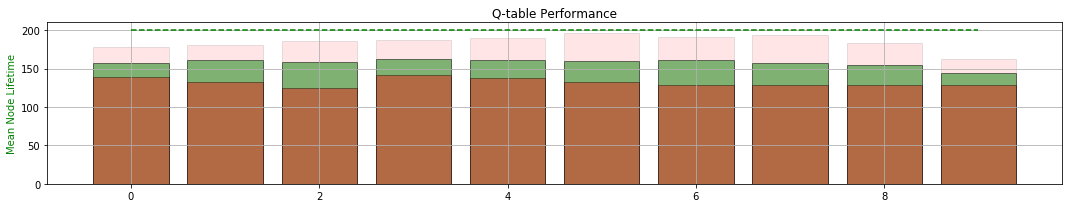

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  8990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  182.135
Validating... MEAN TIME:  154.195
Validating... MEAN TIME:  180.895
Validating... MEAN TIME:  199.98
TRAINING TIME:0:00:46.687833


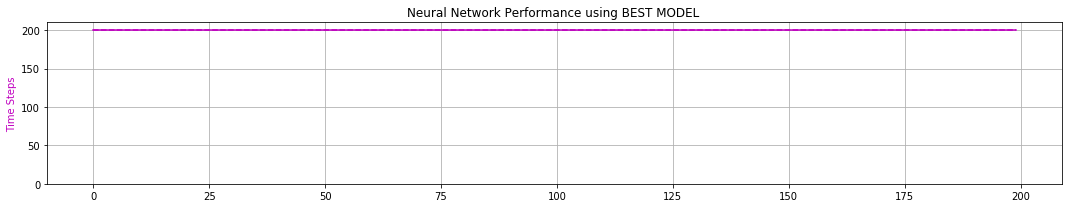

0 -max- [ 0.162  0.634  0.050  0.772  0.549]
0 -min- [-2.371 -2.553 -0.209 -1.129  0.375]

1 -max- [ 0.132  0.633  0.049  0.685  0.600]
1 -min- [-2.353 -2.563 -0.209 -0.923  0.400]

2 -max- [ 0.140  0.804  0.050  0.769  0.649]
2 -min- [-2.394 -2.554 -0.209 -1.099  0.450]

3 -max- [ 0.137  0.635  0.049  0.775  0.699]
3 -min- [-2.352 -2.381 -0.209 -0.918  0.500]

4 -max- [ 0.150  0.812  0.049  0.753  0.750]
4 -min- [-2.386 -2.532 -0.209 -1.157  0.550]

5 -max- [ 0.147  0.780  0.050  0.877  0.800]
5 -min- [-2.398 -2.524 -0.209 -1.144  0.600]

6 -max- [ 0.130  0.813  0.050  0.720  0.848]
6 -min- [-2.399 -2.541 -0.209 -1.117  0.651]

7 -max- [ 0.150  0.980  0.050  0.775  0.900]
7 -min- [-2.398 -2.561 -0.209 -1.403  0.701]

8 -max- [ 0.149  0.828  0.048  0.846  0.925]
8 -min- [-2.398 -2.707 -0.209 -1.161  0.750]

9 -max- [ 0.154  0.826  0.049  0.824  0.925]
9 -min- [-2.399 -2.805 -0.209 -1.182  0.800]

peak memory: 12642.38 MiB, increment: 10284.36 MiB
Quantization TIME:  0.1 minutes


ITERA

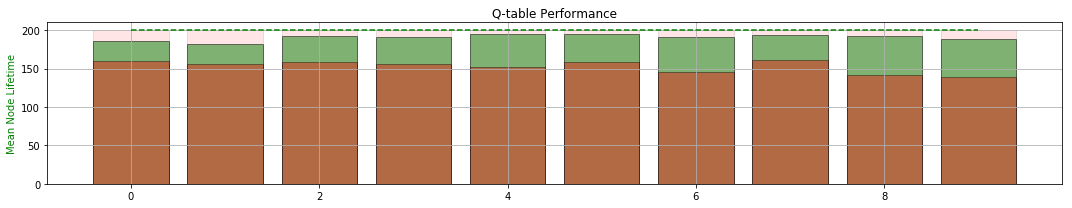

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  9494
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  195.05
Validating... MEAN TIME:  199.42
Validating... MEAN TIME:  185.775
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:49.396462


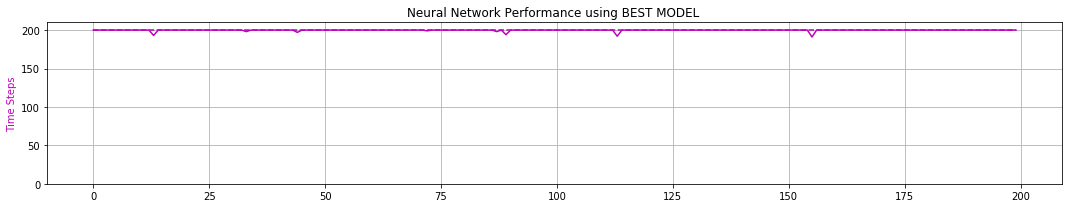

0 -max- [ 0.149  0.594  0.050  0.835  0.550]
0 -min- [-2.358 -2.427 -0.209 -1.097  0.375]

1 -max- [ 0.156  0.618  0.052  0.757  0.599]
1 -min- [-2.375 -2.545 -0.209 -1.266  0.400]

2 -max- [ 0.154  0.608  0.054  0.836  0.649]
2 -min- [-2.360 -2.414 -0.209 -0.984  0.450]

3 -max- [ 0.155  0.777  0.064  0.877  0.700]
3 -min- [-2.324 -2.213 -0.209 -1.077  0.500]

4 -max- [ 0.140  0.887  0.076  0.871  0.749]
4 -min- [-2.312 -2.227 -0.209 -1.317  0.550]

5 -max- [ 0.246  0.982  0.129  1.102  0.800]
5 -min- [-2.252 -2.199 -0.209 -1.268  0.600]

6 -max- [ 0.228  1.110  0.096  0.978  0.850]
6 -min- [-2.393 -2.375 -0.209 -1.198  0.650]

7 -max- [ 0.141  0.935  0.072  0.887  0.899]
7 -min- [-2.380 -2.338 -0.209 -1.310  0.700]

8 -max- [ 0.251  0.975  0.077  0.886  0.925]
8 -min- [-2.352 -2.242 -0.209 -1.283  0.750]

9 -max- [ 0.255  0.988  0.075  0.886  0.925]
9 -min- [-2.390 -2.543 -0.209 -1.303  0.800]

peak memory: 12450.25 MiB, increment: 10059.18 MiB
Quantization TIME:  0.1 minutes


ITERA

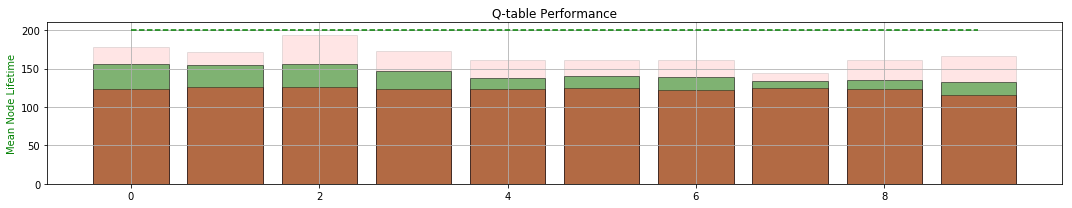

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  10494
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  178.23
Validating... MEAN TIME:  198.645
Validating... MEAN TIME:  188.68
Validating... MEAN TIME:  170.845
TRAINING TIME:0:00:47.432648


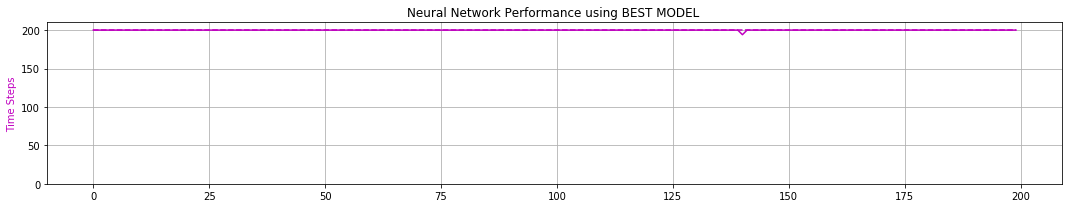

0 -max- [ 0.142  0.632  0.062  0.932  0.550]
0 -min- [-2.304 -2.408 -0.209 -1.212  0.375]

1 -max- [ 0.150  0.758  0.055  0.750  0.600]
1 -min- [-2.369 -2.425 -0.209 -1.235  0.401]

2 -max- [ 0.170  0.799  0.066  0.885  0.650]
2 -min- [-2.389 -2.417 -0.209 -1.136  0.450]

3 -max- [ 0.149  0.808  0.064  0.859  0.700]
3 -min- [-2.391 -2.542 -0.209 -1.180  0.501]

4 -max- [ 0.140  0.807  0.058  0.803  0.749]
4 -min- [-2.391 -2.516 -0.209 -1.312  0.550]

5 -max- [ 0.152  0.633  0.058  0.796  0.800]
5 -min- [-2.394 -2.366 -0.209 -1.134  0.601]

6 -max- [ 0.162  0.800  0.053  0.853  0.850]
6 -min- [-2.392 -2.379 -0.209 -1.277  0.652]

7 -max- [ 0.164  0.807  0.049  0.860  0.899]
7 -min- [-2.364 -2.348 -0.209 -1.141  0.700]

8 -max- [ 0.159  0.809  0.047  0.869  0.925]
8 -min- [-2.399 -2.564 -0.209 -1.154  0.750]

9 -max- [ 0.147  0.828  0.048  0.959  0.925]
9 -min- [-2.392 -2.544 -0.209 -1.265  0.800]

peak memory: 12375.93 MiB, increment: 10011.06 MiB
Quantization TIME:  0.1 minutes


ITERA

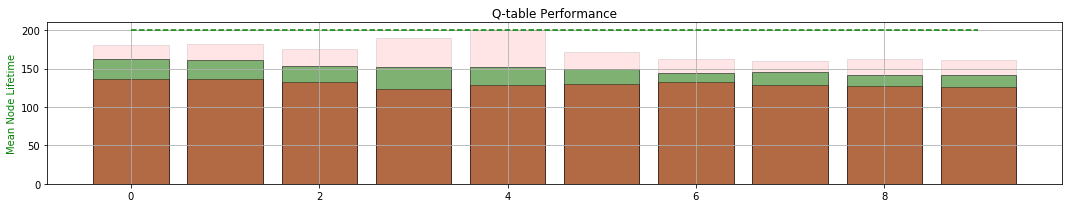

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  11492
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  197.16
Validating... MEAN TIME:  173.28
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  138.195
Validating... MEAN TIME:  189.59
TRAINING TIME:0:00:46.253105


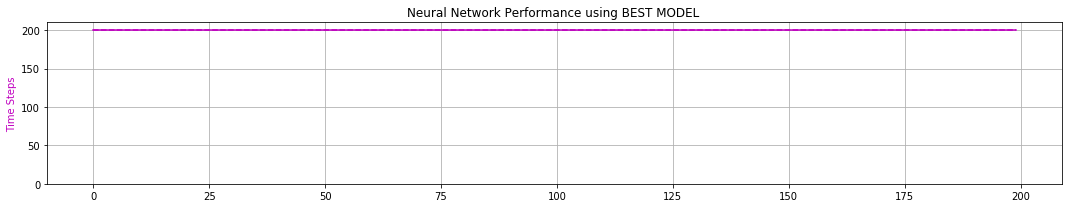

0 -max- [ 0.150  0.634  0.049  0.864  0.549]
0 -min- [-2.174 -2.204 -0.209 -0.924  0.375]

1 -max- [ 0.164  0.634  0.049  0.884  0.599]
1 -min- [-2.331 -2.426 -0.209 -0.959  0.400]

2 -max- [ 0.139  0.632  0.087  0.858  0.650]
2 -min- [-2.361 -2.430 -0.209 -1.152  0.450]

3 -max- [ 0.146  1.026  0.053  0.975  0.698]
3 -min- [-2.364 -2.412 -0.209 -1.506  0.501]

4 -max- [ 0.169  0.734  0.058  0.938  0.750]
4 -min- [-2.323 -2.413 -0.209 -1.110  0.551]

5 -max- [ 0.173  0.802  0.064  0.979  0.799]
5 -min- [-2.312 -2.352 -0.209 -1.220  0.600]

6 -max- [ 0.177  0.759  0.049  0.876  0.850]
6 -min- [-2.355 -2.370 -0.209 -1.118  0.651]

7 -max- [ 0.169  0.794  0.050  0.879  0.900]
7 -min- [-2.366 -2.396 -0.209 -1.135  0.700]

8 -max- [ 0.150  0.823  0.058  0.929  0.925]
8 -min- [-2.358 -2.232 -0.209 -1.260  0.750]

9 -max- [ 0.168  0.801  0.050  0.971  0.925]
9 -min- [-2.394 -2.439 -0.209 -1.219  0.800]

peak memory: 12690.53 MiB, increment: 10323.32 MiB
Quantization TIME:  0.1 minutes


ITERA

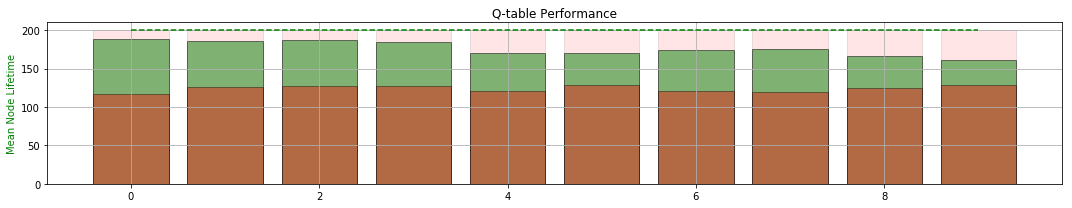

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  12212
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  147.835
Validating... MEAN TIME:  175.49
Validating... MEAN TIME:  189.455
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:46.653683


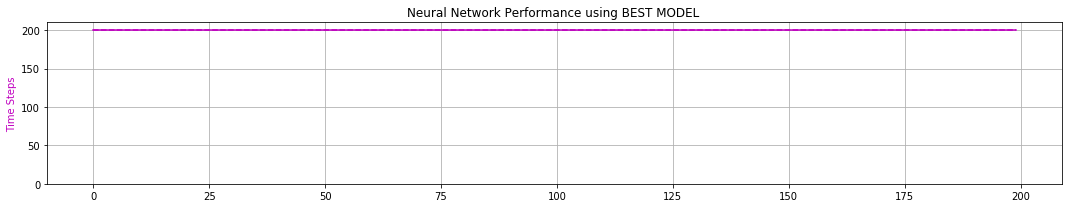

0 -max- [ 0.159  0.784  0.075  1.179  0.550]
0 -min- [-2.056 -2.196 -0.209 -1.170  0.375]

1 -max- [ 0.144  0.635  0.060  1.056  0.600]
1 -min- [-2.146 -2.217 -0.209 -1.118  0.401]

2 -max- [ 0.143  0.827  0.087  0.886  0.649]
2 -min- [-2.201 -2.344 -0.209 -1.232  0.450]

3 -max- [ 0.152  0.791  0.062  1.107  0.699]
3 -min- [-2.216 -2.417 -0.209 -1.116  0.502]

4 -max- [ 0.162  0.812  0.072  1.018  0.750]
4 -min- [-2.391 -2.407 -0.209 -1.152  0.551]

5 -max- [ 0.172  0.818  0.080  0.898  0.800]
5 -min- [-2.373 -2.429 -0.209 -1.203  0.600]

6 -max- [ 0.159  0.809  0.064  0.879  0.849]
6 -min- [-2.312 -2.357 -0.209 -1.154  0.651]

7 -max- [ 0.155  0.830  0.076  0.930  0.899]
7 -min- [-2.309 -2.351 -0.209 -1.205  0.700]

8 -max- [ 0.169  0.827  0.061  0.946  0.925]
8 -min- [-2.400 -2.548 -0.209 -1.210  0.751]

9 -max- [ 0.144  0.819  0.065  0.968  0.925]
9 -min- [-2.400 -2.424 -0.209 -1.233  0.801]

peak memory: 12509.73 MiB, increment: 10131.15 MiB
Quantization TIME:  0.1 minutes


ITERA

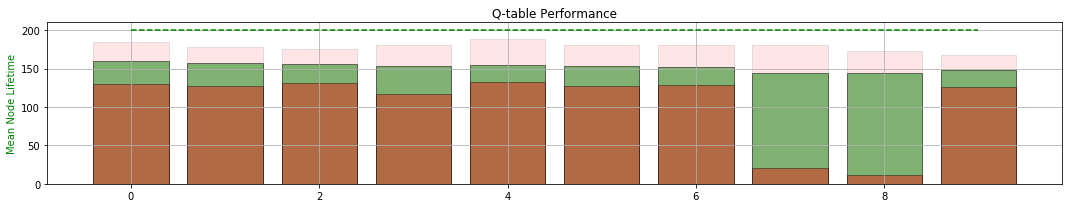

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  13212
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  167.235
Validating... MEAN TIME:  185.755
Validating... MEAN TIME:  193.095
Validating... MEAN TIME:  151.765
Validating... MEAN TIME:  155.255
TRAINING TIME:0:00:44.157401


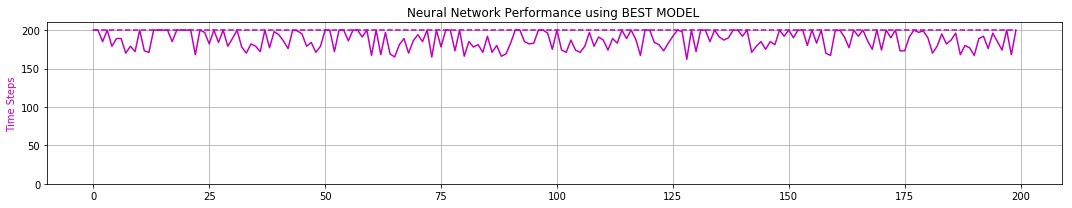

0 -max- [ 0.149  0.780  0.075  1.247  0.550]
0 -min- [-2.178 -2.355 -0.209 -1.307  0.375]

1 -max- [ 0.146  0.820  0.092  1.200  0.600]
1 -min- [-2.085 -2.258 -0.209 -1.318  0.401]

2 -max- [ 0.152  0.820  0.082  1.040  0.650]
2 -min- [-2.212 -2.328 -0.209 -1.454  0.450]

3 -max- [ 0.170  0.828  0.083  1.030  0.700]
3 -min- [-2.304 -2.377 -0.209 -1.520  0.500]

4 -max- [ 0.177  0.826  0.089  1.147  0.749]
4 -min- [-2.326 -2.427 -0.209 -1.587  0.551]

5 -max- [ 0.167  0.827  0.079  1.138  0.800]
5 -min- [-2.365 -2.410 -0.209 -1.318  0.600]

6 -max- [ 0.155  0.830  0.083  1.071  0.849]
6 -min- [-2.355 -2.382 -0.209 -1.325  0.651]

7 -max- [ 0.169  0.995  0.101  1.217  0.900]
7 -min- [-2.309 -2.356 -0.209 -1.473  0.700]

8 -max- [ 0.152  1.023  0.091  1.119  0.925]
8 -min- [-2.398 -2.403 -0.209 -1.461  0.751]

9 -max- [ 0.169  0.989  0.101  1.055  0.925]
9 -min- [-2.391 -2.368 -0.209 -1.543  0.801]

peak memory: 12541.16 MiB, increment: 10221.29 MiB
Quantization TIME:  0.1 minutes


ITERA

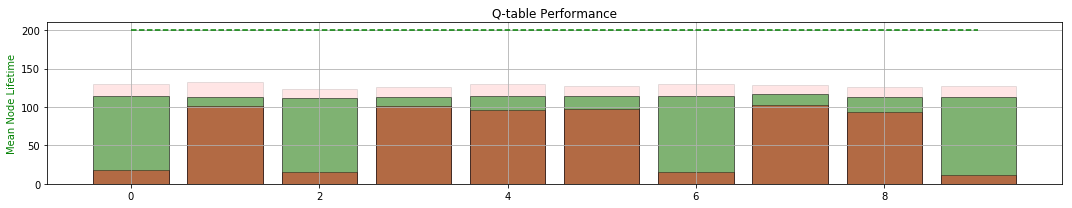

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  14212
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  125.625
Validating... MEAN TIME:  139.505
Validating... MEAN TIME:  121.48
Validating... MEAN TIME:  139.505
Validating... MEAN TIME:  159.625
TRAINING TIME:0:00:37.459481


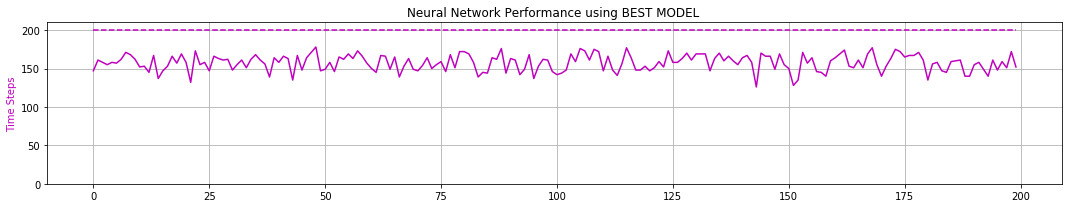

0 -max- [ 0.186  0.827  0.054  0.890  0.550]
0 -min- [-2.300 -2.394 -0.209 -1.293  0.375]

1 -max- [ 0.172  1.019  0.053  1.077  0.599]
1 -min- [-2.346 -2.560 -0.209 -1.472  0.401]

2 -max- [ 0.184  0.994  0.053  0.930  0.650]
2 -min- [-2.379 -2.727 -0.209 -1.441  0.450]

3 -max- [ 0.185  0.948  0.054  0.851  0.700]
3 -min- [-2.394 -2.710 -0.209 -1.488  0.500]

4 -max- [ 0.175  0.827  0.049  0.760  0.749]
4 -min- [-2.380 -2.530 -0.209 -1.312  0.550]

5 -max- [ 0.174  0.830  0.048  0.837  0.799]
5 -min- [-2.393 -2.713 -0.209 -1.272  0.602]

6 -max- [ 0.185  0.832  0.065  1.024  0.850]
6 -min- [-2.399 -2.551 -0.209 -1.265  0.650]

7 -max- [ 0.160  1.015  0.063  0.842  0.900]
7 -min- [-2.387 -2.513 -0.209 -1.447  0.700]

8 -max- [ 0.183  0.832  0.050  0.853  0.925]
8 -min- [-2.392 -2.613 -0.209 -1.275  0.750]

9 -max- [ 0.184  0.984  0.048  0.832  0.925]
9 -min- [-2.398 -2.805 -0.209 -1.510  0.802]

peak memory: 12514.64 MiB, increment: 10164.62 MiB
Quantization TIME:  0.1 minutes


ITERA

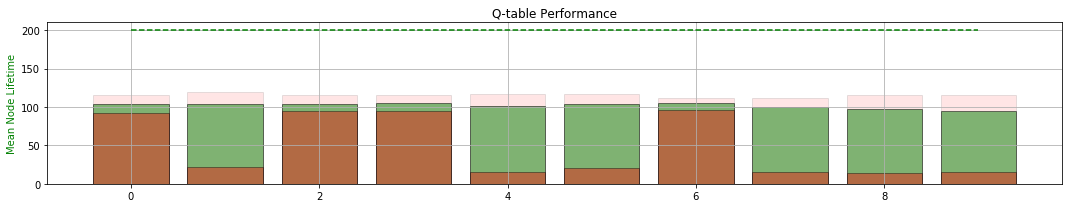

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  15212
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  122.335
Validating... MEAN TIME:  133.295
Validating... MEAN TIME:  115.265
Validating... MEAN TIME:  128.175
Validating... MEAN TIME:  123.395
TRAINING TIME:0:00:34.905205


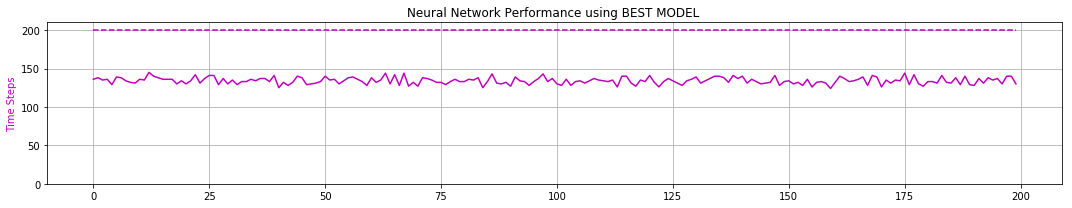

0 -max- [ 0.172  0.827  0.050  0.870  0.549]
0 -min- [-2.398 -2.920 -0.209 -1.270  0.375]

1 -max- [ 0.202  0.828  0.048  1.040  0.600]
1 -min- [-2.370 -2.891 -0.209 -1.186  0.400]

2 -max- [ 0.191  1.009  0.049  0.864  0.650]
2 -min- [-2.394 -2.921 -0.209 -1.402  0.450]

3 -max- [ 0.180  0.827  0.050  1.019  0.700]
3 -min- [-2.400 -2.913 -0.209 -1.229  0.500]

4 -max- [ 0.170  0.830  0.048  0.864  0.750]
4 -min- [-2.399 -2.886 -0.209 -1.239  0.551]

5 -max- [ 0.190  1.010  0.052  1.100  0.800]
5 -min- [-2.399 -2.785 -0.209 -1.427  0.601]

6 -max- [ 0.166  0.933  0.049  0.740  0.850]
6 -min- [-2.400 -2.907 -0.209 -1.441  0.650]

7 -max- [ 0.197  0.985  0.050  0.705  0.900]
7 -min- [-2.400 -2.918 -0.209 -1.517  0.700]

8 -max- [ 0.189  1.023  0.051  0.705  0.925]
8 -min- [-2.399 -2.778 -0.209 -1.526  0.750]

9 -max- [ 0.189  0.958  0.048  0.713  0.925]
9 -min- [-2.397 -2.881 -0.209 -1.487  0.800]

peak memory: 12490.11 MiB, increment: 10129.84 MiB
Quantization TIME:  0.1 minutes


ITERA

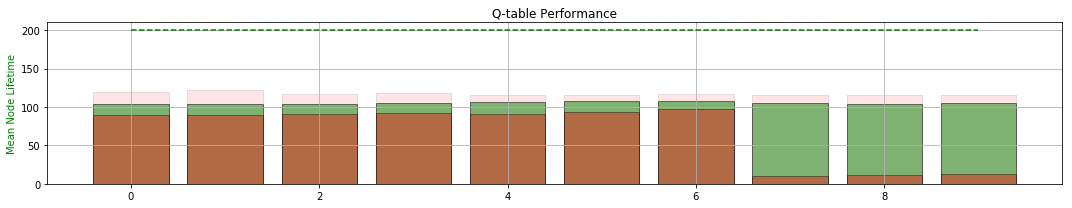

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  16212
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  119.115
Validating... MEAN TIME:  124.1
Validating... MEAN TIME:  112.025
Validating... MEAN TIME:  113.31
Validating... MEAN TIME:  114.135
TRAINING TIME:0:00:33.286469


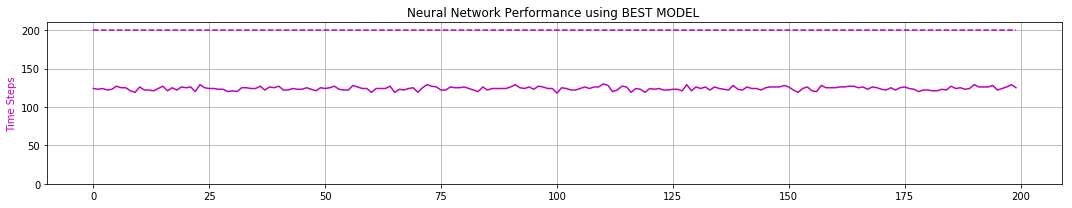

0 -max- [ 0.184  0.828  0.048  1.087  0.550]
0 -min- [-2.399 -2.919 -0.209 -1.243  0.375]

1 -max- [ 0.185  0.826  0.049  0.861  0.600]
1 -min- [-2.399 -2.947 -0.209 -1.224  0.400]

2 -max- [ 0.180  0.992  0.047  0.864  0.650]
2 -min- [-2.398 -2.922 -0.209 -1.505  0.451]

3 -max- [ 0.162  0.830  0.048  0.866  0.699]
3 -min- [-2.400 -2.888 -0.209 -1.256  0.500]

4 -max- [ 0.181  0.956  0.048  1.083  0.749]
4 -min- [-2.399 -2.788 -0.209 -1.483  0.550]

5 -max- [ 0.166  0.935  0.049  0.929  0.797]
5 -min- [-2.399 -2.787 -0.209 -1.473  0.601]

6 -max- [ 0.190  1.009  0.050  0.729  0.848]
6 -min- [-2.398 -2.921 -0.209 -1.495  0.652]

7 -max- [ 0.189  0.993  0.048  0.683  0.900]
7 -min- [-2.399 -2.932 -0.209 -1.588  0.701]

8 -max- [ 0.190  0.999  0.048  0.733  0.925]
8 -min- [-2.399 -2.979 -0.209 -1.554  0.750]

9 -max- [ 0.203  1.016  0.046  1.017  0.925]
9 -min- [-2.400 -2.905 -0.208 -1.505  0.800]

peak memory: 12421.08 MiB, increment: 10052.50 MiB
Quantization TIME:  0.11 minutes


ITER

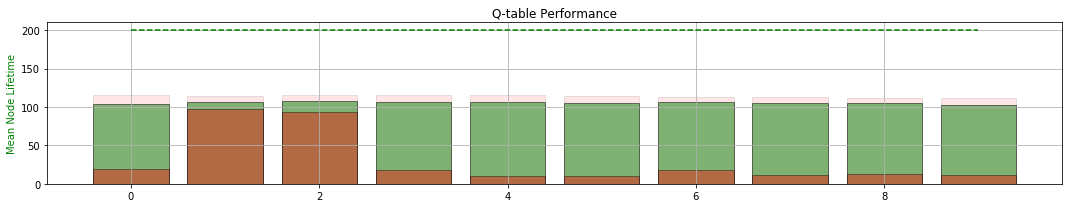

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  17212
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  108.47
Validating... MEAN TIME:  114.41
Validating... MEAN TIME:  116.87
Validating... MEAN TIME:  115.91
Validating... MEAN TIME:  126.52
TRAINING TIME:0:00:33.439725


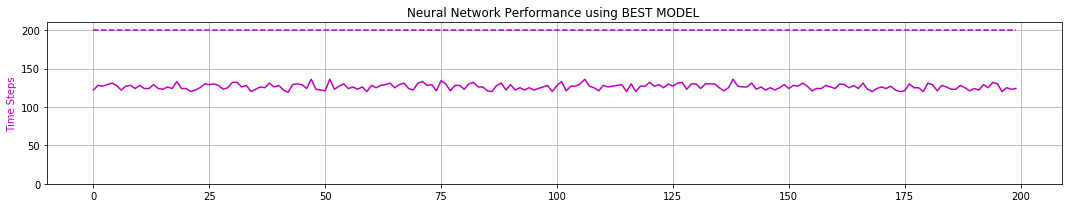

0 -max- [ 0.185  0.827  0.049  0.910  0.549]
0 -min- [-2.400 -2.972 -0.209 -1.267  0.375]

1 -max- [ 0.188  0.995  0.047  0.861  0.599]
1 -min- [-2.400 -2.973 -0.209 -1.453  0.400]

2 -max- [ 0.166  0.831  0.048  0.865  0.649]
2 -min- [-2.399 -2.970 -0.209 -1.269  0.450]

3 -max- [ 0.177  0.975  0.048  1.046  0.700]
3 -min- [-2.399 -2.919 -0.209 -1.465  0.500]

4 -max- [ 0.158  1.018  0.050  0.956  0.748]
4 -min- [-2.399 -2.905 -0.209 -1.578  0.550]

5 -max- [ 0.183  1.203  0.050  0.995  0.800]
5 -min- [-2.400 -2.961 -0.209 -1.696  0.601]

6 -max- [ 0.195  1.176  0.048  1.097  0.850]
6 -min- [-2.400 -2.898 -0.209 -1.699  0.651]

7 -max- [ 0.190  1.187  0.048  0.811  0.900]
7 -min- [-2.398 -2.919 -0.209 -1.659  0.701]

8 -max- [ 0.200  1.211  0.046  0.654  0.925]
8 -min- [-2.399 -2.942 -0.206 -1.659  0.750]

9 -max- [ 0.214  1.201  0.049  0.724  0.925]
9 -min- [-2.400 -2.918 -0.207 -1.730  0.800]

peak memory: 12385.47 MiB, increment: 10016.88 MiB
Quantization TIME:  0.1 minutes


ITERA

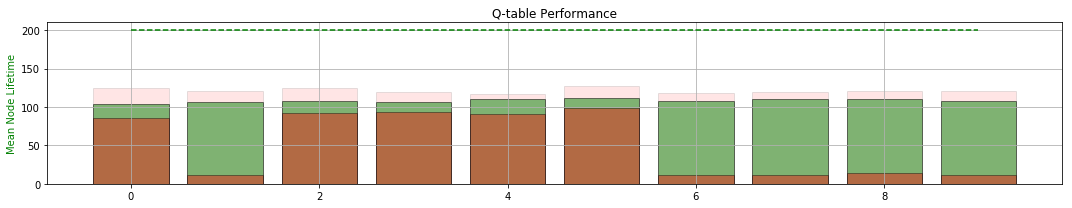

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  18212
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  129.035
Validating... MEAN TIME:  164.05
Validating... MEAN TIME:  146.875
Validating... MEAN TIME:  170.175
Validating... MEAN TIME:  143.035
TRAINING TIME:0:00:40.218484


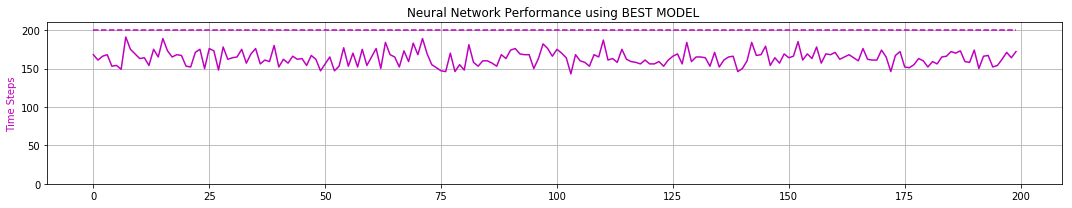

0 -max- [ 0.163  1.011  0.047  1.000  0.550]
0 -min- [-2.397 -2.777 -0.209 -1.468  0.375]

1 -max- [ 0.164  1.408  0.048  1.174  0.600]
1 -min- [-2.398 -2.901 -0.209 -1.965  0.400]

2 -max- [ 0.185  1.130  0.048  1.199  0.650]
2 -min- [-2.398 -2.894 -0.209 -1.664  0.451]

3 -max- [ 0.160  1.014  0.049  1.275  0.700]
3 -min- [-2.399 -2.915 -0.209 -1.459  0.500]

4 -max- [ 0.176  1.203  0.050  1.095  0.749]
4 -min- [-2.399 -2.893 -0.209 -1.696  0.550]

5 -max- [ 0.188  1.218  0.053  1.050  0.800]
5 -min- [-2.399 -2.900 -0.209 -1.726  0.601]

6 -max- [ 0.180  1.196  0.052  1.244  0.849]
6 -min- [-2.399 -2.878 -0.209 -1.740  0.651]

7 -max- [ 0.191  1.366  0.046  1.154  0.900]
7 -min- [-2.400 -2.890 -0.209 -1.996  0.700]

8 -max- [ 0.183  1.206  0.049  1.262  0.925]
8 -min- [-2.400 -2.782 -0.209 -1.747  0.750]

9 -max- [ 0.186  1.390  0.049  1.213  0.925]
9 -min- [-2.399 -2.778 -0.209 -2.009  0.800]

peak memory: 12546.10 MiB, increment: 10177.25 MiB
Quantization TIME:  0.1 minutes


ITERA

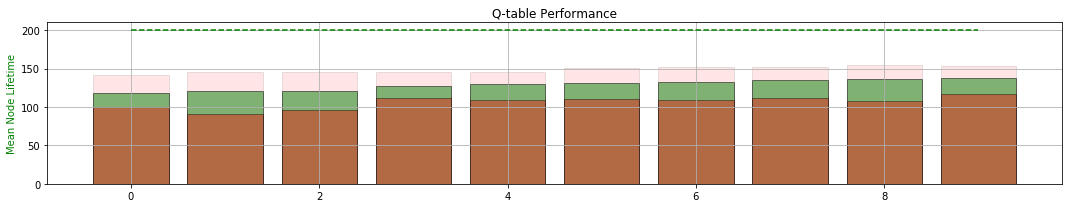

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  19212
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  129.0
Validating... MEAN TIME:  127.365
Validating... MEAN TIME:  138.565
Validating... MEAN TIME:  135.1
Validating... MEAN TIME:  118.31
TRAINING TIME:0:00:36.039455


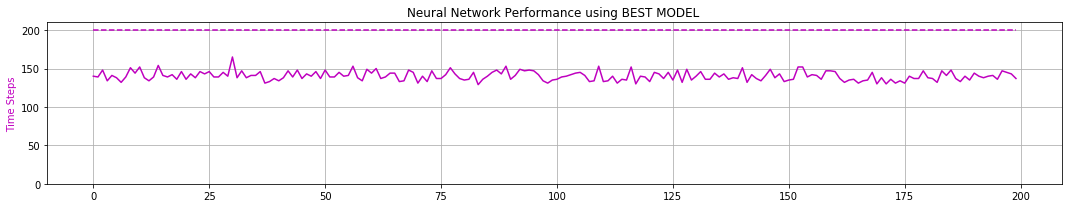

0 -max- [ 0.161  0.830  0.048  0.999  0.549]
0 -min- [-2.393 -2.961 -0.209 -1.305  0.375]

1 -max- [ 0.165  1.008  0.048  1.234  0.598]
1 -min- [-2.399 -2.955 -0.209 -1.546  0.400]

2 -max- [ 0.166  0.981  0.049  1.184  0.650]
2 -min- [-2.399 -2.922 -0.209 -1.510  0.451]

3 -max- [ 0.147  1.179  0.050  1.289  0.700]
3 -min- [-2.398 -2.962 -0.209 -1.663  0.500]

4 -max- [ 0.188  1.176  0.048  1.127  0.750]
4 -min- [-2.399 -2.901 -0.209 -1.699  0.550]

5 -max- [ 0.163  1.187  0.048  1.109  0.800]
5 -min- [-2.399 -2.946 -0.209 -1.680  0.600]

6 -max- [ 0.168  1.171  0.046  1.169  0.850]
6 -min- [-2.399 -2.901 -0.209 -1.658  0.650]

7 -max- [ 0.183  1.189  0.049  1.239  0.900]
7 -min- [-2.399 -2.929 -0.209 -1.652  0.700]

8 -max- [ 0.162  1.142  0.049  1.449  0.925]
8 -min- [-2.400 -2.916 -0.209 -1.692  0.752]

9 -max- [ 0.209  1.138  0.050  1.272  0.925]
9 -min- [-2.397 -2.793 -0.209 -1.680  0.800]

peak memory: 12390.12 MiB, increment: 10010.93 MiB
Quantization TIME:  0.1 minutes


ITERA

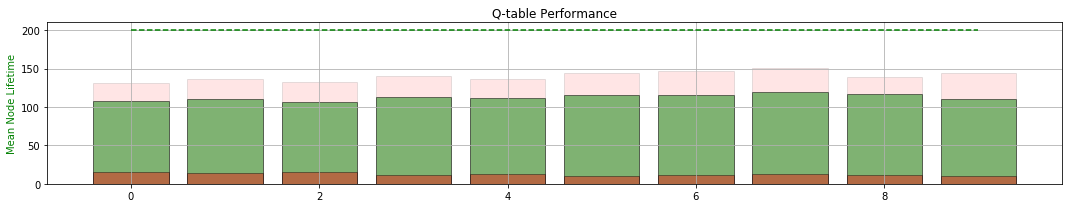

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  20212
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  113.81
Validating... MEAN TIME:  123.43
Validating... MEAN TIME:  119.09
Validating... MEAN TIME:  130.69
Validating... MEAN TIME:  128.76
TRAINING TIME:0:00:35.055788


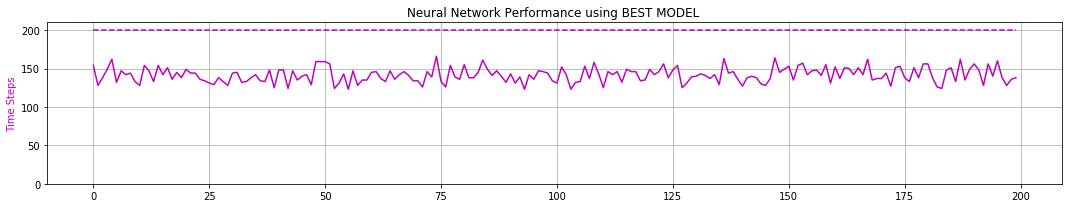

0 -max- [ 0.200  0.983  0.086  1.527  0.549]
0 -min- [-2.399 -3.284 -0.209 -1.433  0.375]

1 -max- [ 0.168  1.014  0.049  1.471  0.599]
1 -min- [-2.400 -3.118 -0.209 -1.468  0.400]

2 -max- [ 0.213  1.138  0.050  1.491  0.648]
2 -min- [-2.395 -3.122 -0.209 -1.684  0.450]

3 -max- [ 0.188  1.372  0.048  1.265  0.700]
3 -min- [-2.398 -3.114 -0.209 -1.983  0.500]

4 -max- [ 0.192  1.213  0.048  1.458  0.750]
4 -min- [-2.398 -3.104 -0.209 -1.696  0.550]

5 -max- [ 0.191  1.210  0.058  1.490  0.800]
5 -min- [-2.398 -2.923 -0.209 -1.739  0.601]

6 -max- [ 0.192  1.207  0.077  1.566  0.850]
6 -min- [-2.400 -2.974 -0.209 -1.747  0.650]

7 -max- [ 0.191  1.217  0.049  1.698  0.900]
7 -min- [-2.398 -2.954 -0.209 -1.746  0.701]

8 -max- [ 0.188  1.216  0.073  1.481  0.925]
8 -min- [-2.400 -2.791 -0.207 -1.771  0.750]

9 -max- [ 0.185  1.208  0.076  1.505  0.925]
9 -min- [-2.400 -2.957 -0.208 -1.752  0.801]

peak memory: 12337.81 MiB, increment: 10011.33 MiB
Quantization TIME:  0.11 minutes


ITER

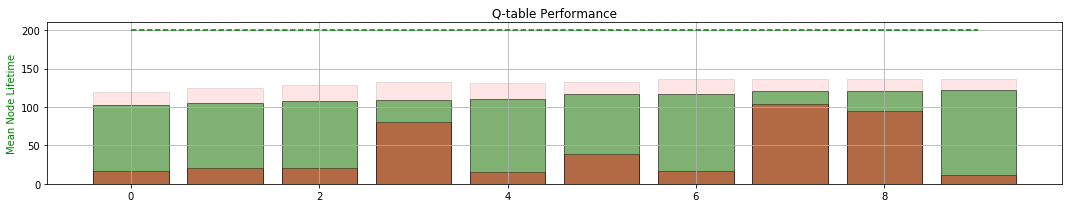

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  21212
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  112.625
Validating... MEAN TIME:  119.095
Validating... MEAN TIME:  127.515
Validating... MEAN TIME:  116.44
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:36.826856


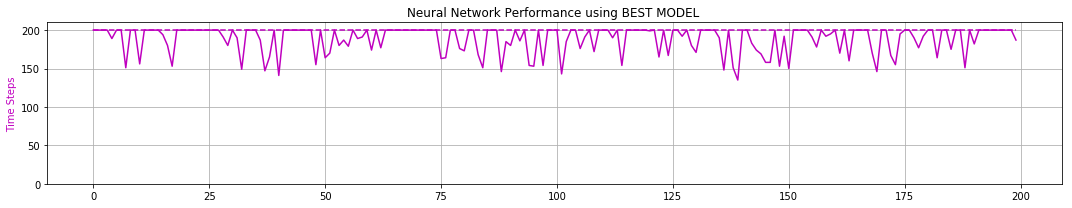

0 -max- [ 0.166  0.827  0.049  1.274  0.550]
0 -min- [-2.398 -3.133 -0.209 -1.261  0.375]

1 -max- [ 0.197  0.830  0.050  1.262  0.599]
1 -min- [-2.400 -3.120 -0.209 -1.250  0.400]

2 -max- [ 0.186  0.948  0.048  1.242  0.650]
2 -min- [-2.399 -3.087 -0.209 -1.475  0.450]

3 -max- [ 0.206  1.020  0.048  1.233  0.699]
3 -min- [-2.399 -3.073 -0.209 -1.523  0.501]

4 -max- [ 0.185  0.930  0.046  1.256  0.750]
4 -min- [-2.396 -2.967 -0.209 -1.482  0.551]

5 -max- [ 0.205  1.013  0.049  1.264  0.800]
5 -min- [-2.400 -2.977 -0.209 -1.611  0.601]

6 -max- [ 0.193  1.014  0.049  1.270  0.850]
6 -min- [-2.400 -2.949 -0.209 -1.571  0.650]

7 -max- [ 0.201  1.007  0.050  1.508  0.900]
7 -min- [-2.400 -2.970 -0.208 -1.508  0.701]

8 -max- [ 0.167  1.008  0.048  1.466  0.925]
8 -min- [-2.399 -2.960 -0.209 -1.439  0.751]

9 -max- [ 0.197  1.011  0.046  1.286  0.925]
9 -min- [-2.399 -2.949 -0.207 -1.478  0.801]

peak memory: 12348.18 MiB, increment: 10011.08 MiB
Quantization TIME:  0.1 minutes


ITERA

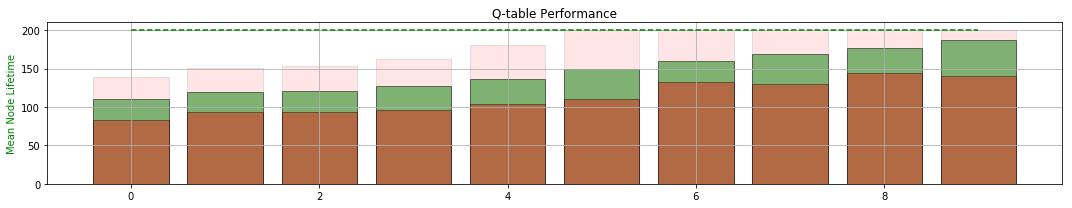

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  22155
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  194.065
Validating... MEAN TIME:  155.535
Validating... MEAN TIME:  101.0
Validating... MEAN TIME:  152.48
Validating... MEAN TIME:  137.805
TRAINING TIME:0:00:39.610523


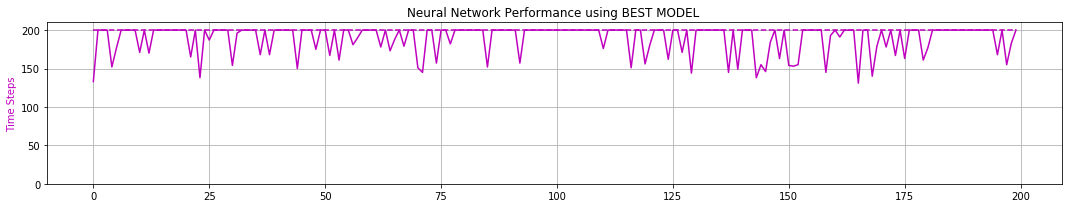

0 -max- [ 0.169  0.984  0.050  1.091  0.549]
0 -min- [-2.400 -3.057 -0.209 -1.377  0.375]

1 -max- [ 0.157  0.829  0.048  0.946  0.600]
1 -min- [-2.400 -3.132 -0.209 -1.267  0.400]

2 -max- [ 0.148  0.941  0.058  1.116  0.647]
2 -min- [-2.400 -2.964 -0.209 -1.425  0.450]

3 -max- [ 0.140  0.829  0.070  1.004  0.700]
3 -min- [-2.399 -2.966 -0.209 -1.191  0.500]

4 -max- [ 0.132  0.926  0.051  0.987  0.750]
4 -min- [-2.399 -2.979 -0.209 -1.448  0.552]

5 -max- [ 0.121  0.931  0.049  0.971  0.799]
5 -min- [-2.398 -2.934 -0.209 -1.523  0.600]

6 -max- [ 0.133  0.825  0.071  1.410  0.850]
6 -min- [-2.399 -2.940 -0.209 -1.236  0.650]

7 -max- [ 0.114  0.932  0.064  1.013  0.900]
7 -min- [-2.400 -2.953 -0.209 -1.347  0.701]

8 -max- [ 0.131  0.825  0.059  1.163  0.925]
8 -min- [-2.398 -2.780 -0.209 -1.238  0.750]

9 -max- [ 0.272  0.806  0.058  1.163  0.925]
9 -min- [-2.397 -2.920 -0.209 -1.211  0.800]

peak memory: 12568.95 MiB, increment: 10196.90 MiB
Quantization TIME:  0.1 minutes


ITERA

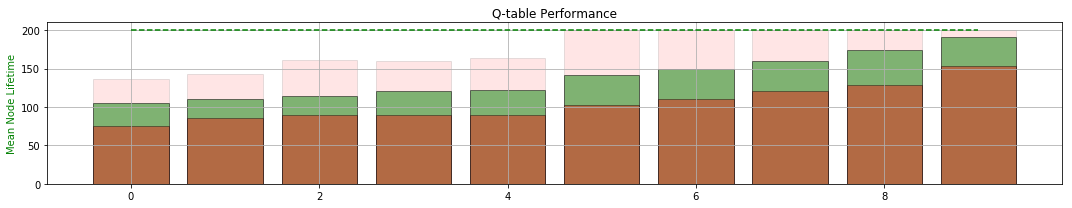

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  23078
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  103.35
Validating... MEAN TIME:  174.08
Validating... MEAN TIME:  98.74
Validating... MEAN TIME:  172.055
Validating... MEAN TIME:  111.015
TRAINING TIME:0:00:36.525233


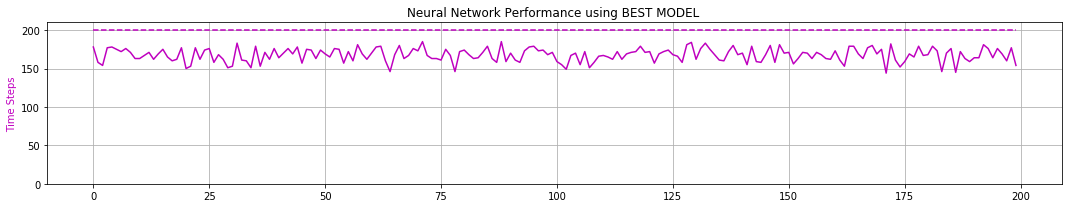

0 -max- [ 0.188  0.828  0.048  1.161  0.550]
0 -min- [-2.399 -3.153 -0.209 -1.204  0.375]

1 -max- [ 0.182  0.831  0.056  1.016  0.600]
1 -min- [-2.400 -3.066 -0.209 -1.221  0.400]

2 -max- [ 0.176  0.981  0.046  1.119  0.649]
2 -min- [-2.400 -3.114 -0.209 -1.459  0.451]

3 -max- [ 0.144  0.957  0.056  0.961  0.699]
3 -min- [-2.398 -2.975 -0.209 -1.440  0.500]

4 -max- [ 0.152  0.827  0.054  1.007  0.750]
4 -min- [-2.399 -3.165 -0.209 -1.234  0.550]

5 -max- [ 0.156  0.825  0.063  0.875  0.799]
5 -min- [-2.397 -2.977 -0.209 -1.194  0.600]

6 -max- [ 0.142  0.941  0.078  0.884  0.849]
6 -min- [-2.399 -2.975 -0.209 -1.280  0.650]

7 -max- [ 0.133  0.829  0.078  1.314  0.900]
7 -min- [-2.400 -2.971 -0.209 -1.194  0.700]

8 -max- [ 0.129  0.808  0.067  1.152  0.925]
8 -min- [-2.400 -2.899 -0.209 -1.221  0.750]

9 -max- [ 0.116  0.820  0.081  0.953  0.925]
9 -min- [-2.398 -2.907 -0.209 -1.198  0.800]

peak memory: 12737.41 MiB, increment: 10343.32 MiB
Quantization TIME:  0.1 minutes


ITERA

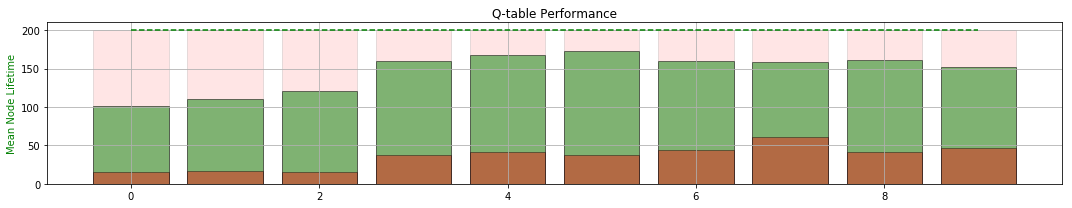

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  23814
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  137.29
Validating... MEAN TIME:  156.635
Validating... MEAN TIME:  156.815
Validating... MEAN TIME:  171.245
Validating... MEAN TIME:  196.025
TRAINING TIME:0:00:43.171877


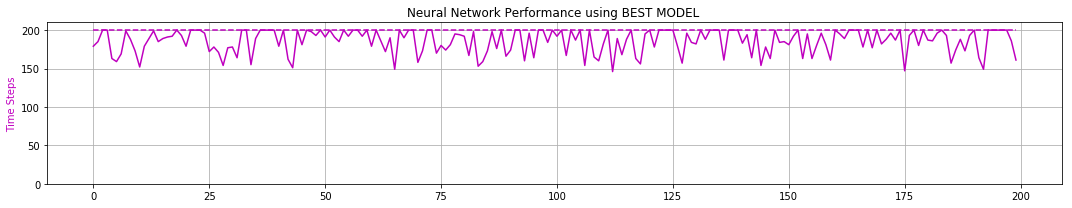

0 -max- [ 0.194  0.824  0.058  1.226  0.550]
0 -min- [-2.400 -3.262 -0.209 -1.240  0.375]

1 -max- [ 0.190  0.822  0.074  1.209  0.599]
1 -min- [-2.400 -3.295 -0.209 -1.222  0.400]

2 -max- [ 0.268  0.983  0.083  1.236  0.649]
2 -min- [-2.400 -3.287 -0.209 -1.414  0.450]

3 -max- [ 0.250  1.135  0.072  1.286  0.699]
3 -min- [-2.399 -3.262 -0.209 -1.557  0.500]

4 -max- [ 0.260  1.134  0.077  1.272  0.750]
4 -min- [-2.398 -3.438 -0.209 -1.541  0.550]

5 -max- [ 0.298  1.002  0.110  1.355  0.800]
5 -min- [-2.399 -3.321 -0.209 -1.392  0.601]

6 -max- [ 0.430  0.995  0.078  1.265  0.850]
6 -min- [-2.400 -3.341 -0.208 -1.427  0.651]

7 -max- [ 0.414  0.941  0.079  1.254  0.900]
7 -min- [-2.399 -3.338 -0.209 -1.242  0.700]

8 -max- [ 0.336  0.832  0.084  1.288  0.925]
8 -min- [-2.395 -3.318 -0.209 -1.271  0.750]

9 -max- [ 0.369  0.993  0.085  1.442  0.925]
9 -min- [-2.399 -3.331 -0.209 -1.243  0.800]

peak memory: 12368.24 MiB, increment: 10029.02 MiB
Quantization TIME:  0.1 minutes


ITERA

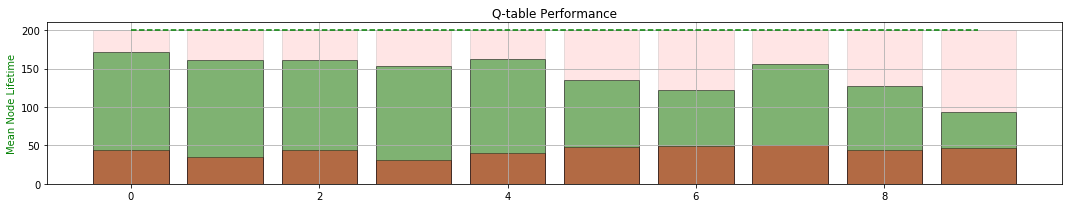

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  24473
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  166.015
Validating... MEAN TIME:  117.32
Validating... MEAN TIME:  109.54
Validating... MEAN TIME:  108.41
Validating... MEAN TIME:  110.135
TRAINING TIME:0:00:34.875435


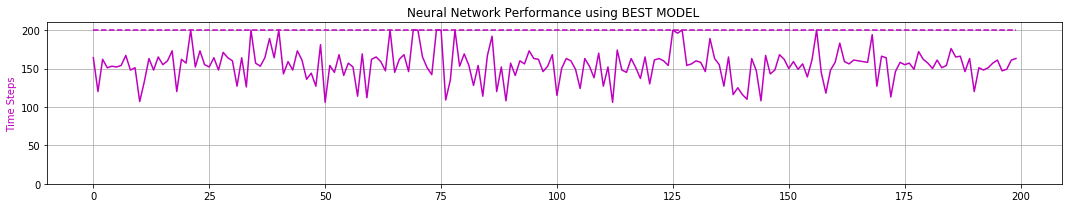

0 -max- [ 0.200  0.783  0.060  1.100  0.549]
0 -min- [-2.396 -3.135 -0.207 -1.107  0.375]

1 -max- [ 0.285  0.986  0.056  0.773  0.600]
1 -min- [-2.400 -2.978 -0.209 -1.306  0.401]

2 -max- [ 0.429  1.014  0.083  0.855  0.649]
2 -min- [-2.397 -2.954 -0.209 -1.332  0.450]

3 -max- [ 0.419  1.116  0.110  1.125  0.700]
3 -min- [-2.399 -2.958 -0.209 -1.417  0.500]

4 -max- [ 0.299  1.117  0.086  0.890  0.750]
4 -min- [-2.393 -2.948 -0.209 -1.406  0.551]

5 -max- [ 0.431  1.019  0.087  1.421  0.800]
5 -min- [-2.398 -2.871 -0.209 -1.332  0.601]

6 -max- [ 0.504  1.002  0.081  0.804  0.849]
6 -min- [-2.396 -2.791 -0.209 -1.285  0.650]

7 -max- [ 0.463  1.134  0.094  0.959  0.900]
7 -min- [-2.400 -2.918 -0.209 -1.317  0.700]

8 -max- [ 0.462  1.102  0.101  1.134  0.925]
8 -min- [-2.398 -2.772 -0.209 -1.145  0.752]

9 -max- [ 0.446  1.326  0.103  1.234  0.925]
9 -min- [-2.395 -2.910 -0.209 -1.292  0.802]

peak memory: 12410.21 MiB, increment: 10044.36 MiB
Quantization TIME:  0.1 minutes


ITERA

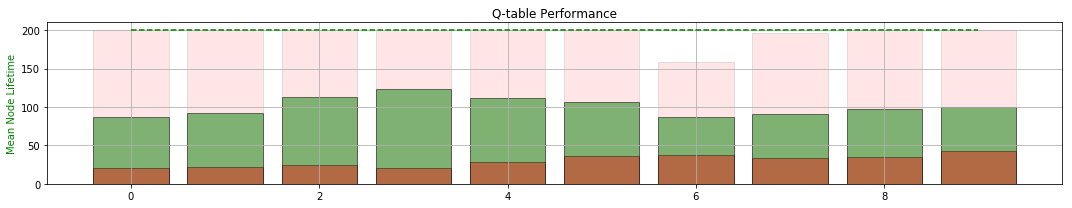

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  25416
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  127.965
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  176.755
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:46.231744


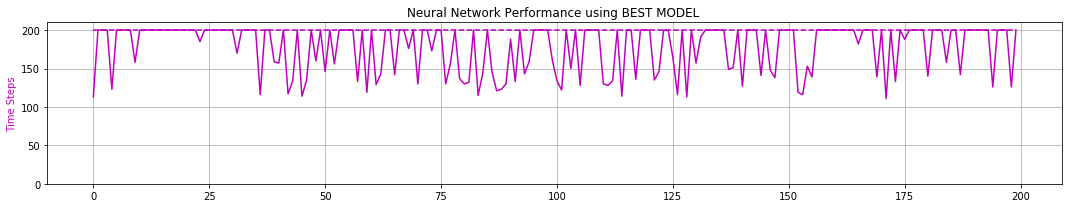

0 -max- [ 0.201  0.930  0.070  0.805  0.550]
0 -min- [-2.397 -3.266 -0.209 -1.238  0.375]

1 -max- [ 0.298  1.141  0.061  1.097  0.598]
1 -min- [-2.400 -3.313 -0.209 -1.494  0.400]

2 -max- [ 0.306  1.017  0.067  1.273  0.649]
2 -min- [-2.400 -3.319 -0.209 -1.423  0.451]

3 -max- [ 0.287  1.113  0.077  1.127  0.700]
3 -min- [-2.400 -3.446 -0.209 -1.341  0.500]

4 -max- [ 0.319  1.139  0.076  0.837  0.750]
4 -min- [-2.400 -3.324 -0.209 -1.414  0.550]

5 -max- [ 0.329  1.366  0.082  0.917  0.800]
5 -min- [-2.396 -3.426 -0.209 -1.609  0.600]

6 -max- [ 0.371  1.200  0.088  0.802  0.849]
6 -min- [-2.400 -3.321 -0.209 -1.339  0.650]

7 -max- [ 0.468  1.283  0.093  0.794  0.900]
7 -min- [-2.392 -3.260 -0.209 -1.414  0.700]

8 -max- [ 0.440  1.336  0.111  1.078  0.925]
8 -min- [-2.400 -3.456 -0.209 -1.409  0.750]

9 -max- [ 0.428  1.368  0.140  0.979  0.925]
9 -min- [-2.394 -3.320 -0.209 -1.468  0.802]

peak memory: 12406.20 MiB, increment: 10040.09 MiB
Quantization TIME:  0.1 minutes


ITERA

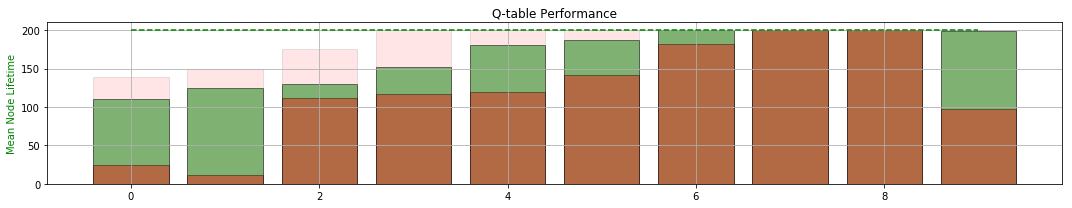

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  25924
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  198.505
Validating... MEAN TIME:  139.67
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  170.03
TRAINING TIME:0:00:46.279885


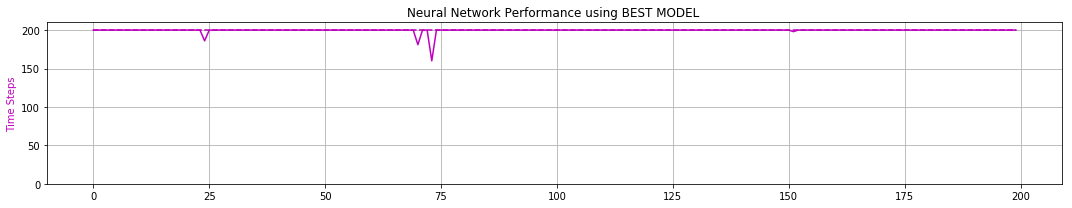

0 -max- [ 0.181  0.827  0.049  1.566  0.549]
0 -min- [-2.398 -3.133 -0.209 -1.204  0.375]

1 -max- [ 0.189  0.827  0.061  1.564  0.599]
1 -min- [-2.400 -3.119 -0.209 -1.253  0.401]

2 -max- [ 0.137  1.012  0.048  1.600  0.650]
2 -min- [-2.400 -3.085 -0.207 -1.433  0.450]

3 -max- [ 0.161  0.822  0.046  1.176  0.700]
3 -min- [-2.399 -2.937 -0.204 -1.187  0.500]

4 -max- [ 0.163  0.800  0.049  1.281  0.750]
4 -min- [-2.399 -2.742 -0.207 -1.145  0.552]

5 -max- [ 0.214  0.792  0.066  1.188  0.799]
5 -min- [-2.398 -2.606 -0.199 -1.037  0.600]

6 -max- [ 0.277  1.151  0.079  1.257  0.850]
6 -min- [-2.389 -2.562 -0.207 -1.344  0.650]

7 -max- [ 0.391  1.130  0.082  1.406  0.900]
7 -min- [-1.177 -1.746 -0.158 -1.328  0.701]

8 -max- [ 0.480  1.342  0.098  1.265  0.925]
8 -min- [-1.420 -1.868 -0.163 -1.326  0.751]

9 -max- [ 0.470  1.351  0.111  1.300  0.925]
9 -min- [-0.779 -1.543 -0.190 -1.568  0.801]

peak memory: 12388.28 MiB, increment: 10010.92 MiB
Quantization TIME:  0.1 minutes


ITERA

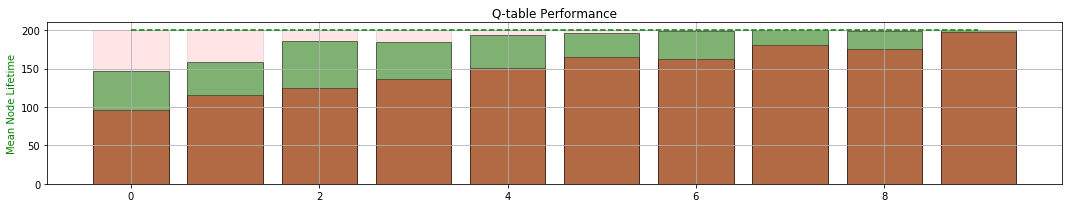

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  26285
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  197.615
Validating... MEAN TIME:  110.945
Validating... MEAN TIME:  110.785
Validating... MEAN TIME:  101.665
Validating... MEAN TIME:  188.93
TRAINING TIME:0:00:38.542912


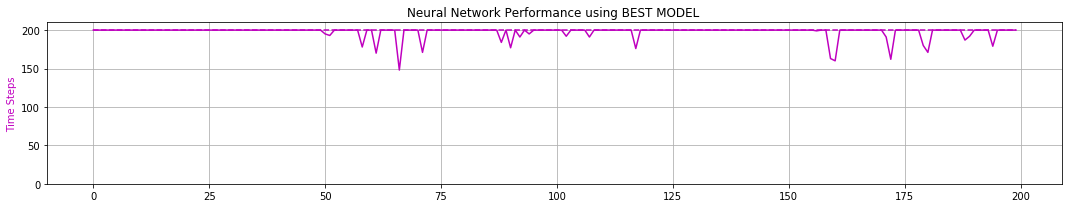

0 -max- [ 0.185  0.833  0.050  1.135  0.549]
0 -min- [-2.398 -3.139 -0.209 -1.301  0.375]

1 -max- [ 0.177  0.813  0.048  1.131  0.600]
1 -min- [-2.400 -2.893 -0.209 -1.167  0.401]

2 -max- [ 0.188  0.947  0.050  0.862  0.649]
2 -min- [-2.398 -2.783 -0.209 -1.306  0.450]

3 -max- [ 0.158  0.826  0.049  0.881  0.699]
3 -min- [-2.400 -2.767 -0.209 -1.158  0.500]

4 -max- [ 0.165  0.773  0.068  0.783  0.750]
4 -min- [-2.399 -2.775 -0.208 -1.059  0.550]

5 -max- [ 0.223  1.118  0.071  0.759  0.800]
5 -min- [-2.396 -2.725 -0.209 -1.285  0.600]

6 -max- [ 0.434  1.139  0.072  0.886  0.849]
6 -min- [-2.367 -2.719 -0.208 -1.414  0.651]

7 -max- [ 0.413  1.129  0.077  0.940  0.900]
7 -min- [-2.395 -2.509 -0.208 -1.307  0.700]

8 -max- [ 0.433  1.165  0.080  1.151  0.925]
8 -min- [-2.393 -2.610 -0.209 -1.335  0.750]

9 -max- [ 0.399  1.333  0.085  1.046  0.925]
9 -min- [-2.313 -2.372 -0.209 -1.475  0.801]

peak memory: 12388.44 MiB, increment: 10011.86 MiB
Quantization TIME:  0.1 minutes


ITERA

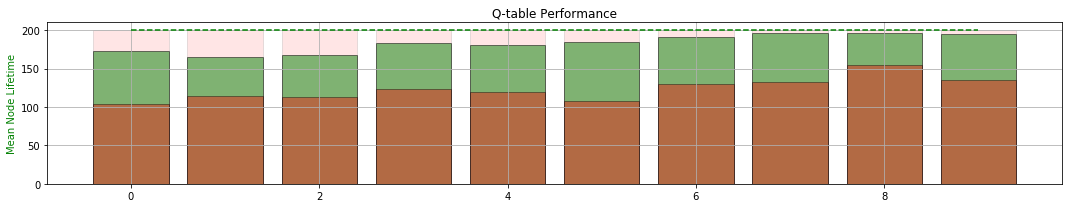

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  26728
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  190.22
Validating... MEAN TIME:  141.33
Validating... MEAN TIME:  190.885
Validating... MEAN TIME:  139.86
Validating... MEAN TIME:  191.53
TRAINING TIME:0:00:44.188612


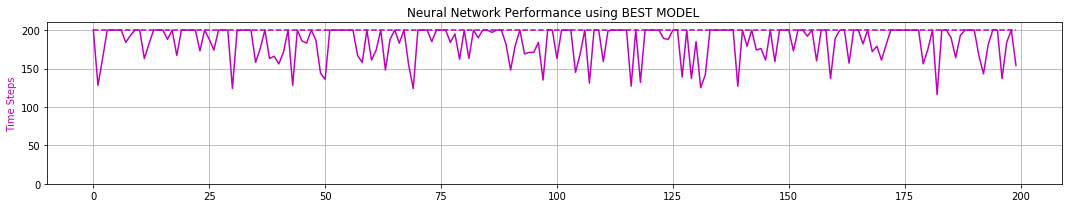

0 -max- [ 0.223  0.813  0.087  1.195  0.550]
0 -min- [-2.399 -3.109 -0.209 -1.074  0.375]

1 -max- [ 0.155  0.735  0.051  0.867  0.600]
1 -min- [-2.400 -3.112 -0.209 -1.143  0.401]

2 -max- [ 0.192  0.606  0.049  0.784  0.649]
2 -min- [-2.399 -3.101 -0.209 -0.822  0.450]

3 -max- [ 0.193  0.577  0.050  0.759  0.699]
3 -min- [-2.399 -2.957 -0.209 -0.829  0.500]

4 -max- [ 0.405  1.006  0.050  0.910  0.749]
4 -min- [-2.398 -2.969 -0.209 -1.147  0.550]

5 -max- [ 0.406  0.792  0.065  0.998  0.800]
5 -min- [-2.399 -2.951 -0.209 -0.863  0.600]

6 -max- [ 0.490  0.788  0.081  1.139  0.849]
6 -min- [-2.399 -2.941 -0.209 -0.855  0.651]

7 -max- [ 0.664  1.304  0.084  1.279  0.900]
7 -min- [-2.398 -2.931 -0.200 -1.344  0.700]

8 -max- [ 0.598  0.995  0.076  1.109  0.925]
8 -min- [-2.399 -2.943 -0.204 -0.961  0.751]

9 -max- [ 0.621  0.971  0.067  0.891  0.925]
9 -min- [-2.396 -2.794 -0.205 -0.886  0.800]

peak memory: 12398.36 MiB, increment: 10011.07 MiB
Quantization TIME:  0.1 minutes


In [19]:
while iteration < MAX_NO_OF_ITERATIONS:
    if iteration < 3:
        node_EPSILON   = (iteration+1) * 0.2
    else:
        node_EPSILON   = T_EPSILON
    
    print("\n")
    print("ITERATION #", iteration)
    print("MEAN TABULAR EPSILON = ", node_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
    bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


    dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
    dqn.good_memory_counter += good_mem.shape[0]

    dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
    dqn.bad_memory_counter += bad_mem.shape[0]

    dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
    dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS

    print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
    print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    
    for node_id in range(NO_OF_NODES):
#         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
#         ###############################################
        [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
         C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
#         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
#         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
#                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
#         # CREATE STATE COMBINATIONS
#         ###############################################

    node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                        [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                        [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
        ###############################################
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

    # SAVE QFILE
    np.save(node_QFILE, node_q_table)
        #############################################################################################################################################
    stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [20]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  5160.0
Total Serial Timesteps   :  3975256.0
Speed-up                 :  770.40


In [21]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [22]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

   314 FAILURE 104  30    5160    3975256     770.40
